In [422]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
import csv
import re
import string
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.lines import Line2D



In [423]:

def transformDataframe(frame):
#     frame['texture'] = frame.apply (lambda row: row.imagename.split('_')[6].split('.')[0].split('-')[1].rstrip(string.digits), axis=1)
    frame['texture'] = frame.apply (lambda row: row.imagename.split('\\')[2].split('.')[0].split('-')[1].rstrip(string.digits), axis=1)
    frame['correct_t'] = frame.apply(lambda row:  1 if row.object_response == row.texture else 0, axis=1)
    frame['correct_s'] =  frame.apply(lambda row:  1 if row.object_response == row.category else 0, axis=1)
    frame['correct'] = frame.apply(lambda row:  1 if row.correct_t == 1 or row.correct_s == 1 else 0, axis=1)
    frame['total'] = frame.apply(lambda row:  1, axis=1)

    return frame[['texture', 'category','correct_t', 'correct_s', 'correct', 'total']]

In [424]:
# directory = "../raw-data/style-transfer-512-nomask-experiment/"
directory ="./results/"
datafiles = [f for f in listdir(directory) if isfile(join(directory, f)) and f.endswith('.csv') and 'subject' not in f]
scatterdata = {}
modelname = re.compile('experiment_(.*)_session')
for file in datafiles:
    name = modelname.findall(file)[0]
    if name:
        filedata = pd.read_csv(directory+file)
        filedata = transformDataframe(filedata)
        summed_filedata = filedata.groupby(['category']).sum()
        summed_filedata['correct_fraction'] = summed_filedata['correct'] / summed_filedata['total']
        print(name)
        display(summed_filedata)
        only_cue = filedata[filedata.texture != filedata.category]
        summed_only_cue = only_cue.groupby(['category']).sum()
        summed_only_cue['shape_fraction'] = summed_only_cue['correct_s'] / summed_only_cue['correct']
        summed_only_cue['texture_fraction'] = summed_only_cue['correct_t'] / summed_only_cue['correct']
        scatterdata[name] = pd.concat([summed_only_cue[['shape_fraction', 'correct_s', 'correct']], summed_filedata[['correct_fraction']]], axis=1)
        

    
barplotdata= {}
for name in scatterdata:
    for row in scatterdata[name].itertuples():
        if row.Index not in barplotdata:
            barplotdata[row.Index] = {}
        barplotdata[row.Index][name] = row.correct_fraction

alexnet


,correct_t,correct_s,correct,total,correct_fraction
category,,,,,
airplane,43,14,55,80,0.6875
bear,46,8,49,80,0.6125
bicycle,25,25,46,80,0.5750
bird,37,5,39,80,0.4875
boat,42,2,43,80,0.5375
bottle,39,23,58,80,0.7250
car,34,22,52,80,0.6500
cat,37,11,44,80,0.5500
chair,42,20,57,80,0.7125


googlenet


,correct_t,correct_s,correct,total,correct_fraction
category,,,,,
airplane,3,1,4,80,0.0500
bear,7,0,7,80,0.0875
bicycle,4,1,5,80,0.0625
bird,5,0,5,80,0.0625
boat,6,0,6,80,0.0750
bottle,8,18,25,80,0.3125
car,7,0,7,80,0.0875
cat,7,1,8,80,0.1000
chair,5,5,10,80,0.1250


resnet101


,correct_t,correct_s,correct,total,correct_fraction
category,,,,,
airplane,4,0,4,80,0.0500
bear,4,0,4,80,0.0500
bicycle,6,0,6,80,0.0750
bird,6,0,6,80,0.0750
boat,5,0,5,80,0.0625
bottle,5,77,77,80,0.9625
car,5,0,5,80,0.0625
cat,7,0,7,80,0.0875
chair,7,0,7,80,0.0875


resnet50


,correct_t,correct_s,correct,total,correct_fraction
category,,,,,
airplane,5,0,5,80,0.0625
bear,5,0,5,80,0.0625
bicycle,6,0,6,80,0.0750
bird,5,0,5,80,0.0625
boat,5,0,5,80,0.0625
bottle,5,80,80,80,1.0000
car,5,0,5,80,0.0625
cat,5,0,5,80,0.0625
chair,5,0,5,80,0.0625


vgg16


,correct_t,correct_s,correct,total,correct_fraction
category,,,,,
airplane,50,6,53,80,0.6625
bear,53,6,54,80,0.6750
bicycle,48,7,51,80,0.6375
bird,62,5,62,80,0.7750
boat,56,2,56,80,0.7000
bottle,54,16,65,80,0.8125
car,47,23,65,80,0.8125
cat,56,13,64,80,0.8000
chair,57,6,58,80,0.7250


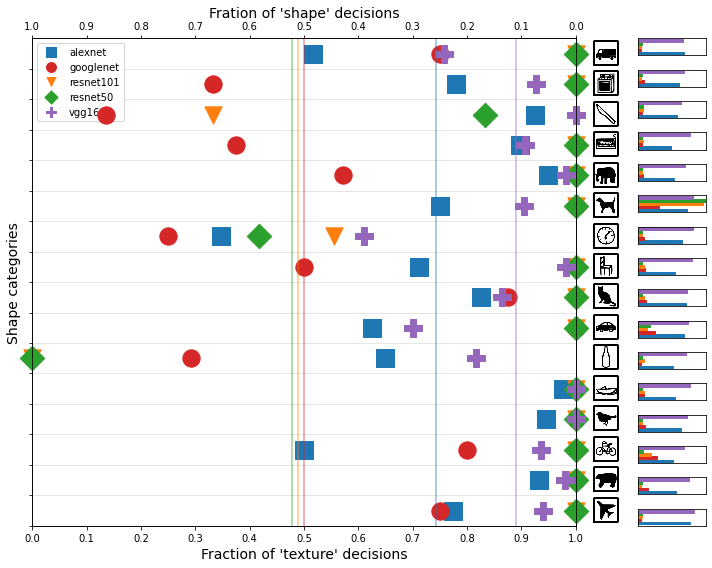

In [425]:
fig = plt.figure(figsize=(10,8))
spec2 = fig.add_gridspec(16, 16)
main = fig.add_subplot(spec2[:, 0:13])

xticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
main.set_xticks(xticks)
main.set_ylim(0, 16)
main.set_yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
main.set_yticklabels([])
main.yaxis.grid(True, alpha=0.4)
main.set_xlabel("Fraction of 'texture' decisions", fontsize=14)
main.set_ylabel('Shape categories', fontsize=14)

shapeAxis = main.twiny()
shapeAxis.set_xticks(xticks)
shapeAxis.set_xlim(0, 1)
shapeAxis.invert_xaxis()
shapeAxis.set_xlabel("Fration of 'shape' decisions", fontsize=14)

for i, label in enumerate(scatterdata[next(iter(scatterdata))].index.values):
        img = plt.imread(f'../data-analysis/category-images/{label}.png')
        im = OffsetImage(img, zoom=0.20)
        im.image.axes = main
        ab = AnnotationBbox(im, (1, i), xybox=(30, 16), frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)
        main.add_artist(ab)

colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green', 'tab:purple', 'tab:cyan', 'tab:gray']
markers = ['s', 'o', 'v', 'D', 'P', 'p', '*']

legend_elements = []
for i, item in enumerate(scatterdata):
    x_avg = scatterdata[item].correct_s.mean() / scatterdata[item].correct.mean()
    plt.plot([x_avg, x_avg], [0, 16], c=colors[i], alpha=0.5)
    scatter = plt.scatter(scatterdata[item].shape_fraction.values, np.arange(0, 16) + 0.5, s=300, c=colors[i],  marker=markers[i])
    scatter.set_clip_on(False)
    legend_elements.append(Line2D([0], [0], color='w', markerfacecolor=colors[i], markersize=12, marker=markers[i], label=item))
   
    
    
    
for i, category in enumerate(scatterdata[item].index.values):
    barfig = fig.add_subplot(spec2[i, 14:16])
    barfig.set_xlim(0, 1)
    barfig.xaxis.set_visible(False)
    barfig.yaxis.set_visible(False)
    y_pos = np.arange(len(barplotdata[category]))
    barplot = barfig.barh(y_pos, barplotdata[category].values(), align='center')
    for j in y_pos:
        barplot[j].set_color(colors[j])

main.legend(handles=legend_elements, loc='upper left')
plt.tight_layout()
plt.margins(0.1)
plt.show()



